## Guest Lecture COMP7230
# Using Python packages for Linked Data & spatial data
#### by Dr Nicholas Car

This Notebook is the resource used to deliver a guest lecture for the [Australian National University](https://www.anu.edu.au)'s course [COMP7230](https://programsandcourses.anu.edu.au/2020/course/COMP7230): *Introduction to Programming for Data Scientists*

Click here to run this lecture in your web browser:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nicholascar/comp7230-training/HEAD?filepath=lecture.ipynb)

## About the lecturer
**Nicholas Car**:
* PhD in informatics for irrigation
* A former CSIRO informatics researcher
    * worked on integrating environmental data across government / industry
    * developed data standards
* Has worked in operation IT in government
* Now in a private IT consulting company, [SURROUND Australia Pty Ltd](https://surroundaustralia.com) supplying Data Science solutions

Relevant current work:

* building data processing systems for government & industry
* mainly using Python
    * due to its large number of web and data science packages
* maintains the [RDFlib](https://rdflib.net) Python toolkit
    * for processing [RDF](https://en.wikipedia.org/wiki/Resource_Description_Framework)
* co-chairs the [Australian Government Linked Data Working Group](https://www.linked.data.gov.au) with Armin Haller
    * plans for multi-agency data integration
* still developing data standards
    * in particular GeoSPARQL 1.1 (https://opengeospatial.github.io/ogc-geosparql/geosparql11/spec.html) 
        * for graph representations of spatial information


## 0. Lecture Outline
1. Notes about this training material
2. Accessing RDF data
3. Parsing RDF data
4. Data 'mash up'
5. Data Conversions & Display


## 1. Notes about this training material

#### This tool
* This is a Jupyter Notebook - interactive Python scripting
* You will cover Jupyter Notebooks more, later in this course
* Access this material online at:
    * GitHub: <https://github.com/nicholascar/comp7230-training>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nicholascar/comp7230-training/?filepath=lecture.ipynb)

#### Background data concepts - RDF

_Nick will talk RDF using these web pages:_

* [Semantic Web](https://www.w3.org/standards/semanticweb/) - the concept
* [RDF](https://en.wikipedia.org/wiki/Resource_Description_Framework) - the data model
    * refer to the RDF image below
* [RDFlib](https://rdflib.net) - the (Python) toolkit
* [RDFlib training Notebooks are available](https://github.com/surroundaustralia/rdflib-training)

The LocI project:
* The Location Index project: <http://loci.cat>

RDF image, from [the RDF Primer](https://www.w3.org/TR/rdf11-primer/), for discussion:

![](img/example-graph-iris.jpg)

Note that:
* _everything_ is "strongly" identified
    * including all relationships
    * unlike lots of related data
* many of the identifiers resolve
    * to more info (on the web)

## 2. Accessing RDF data

* Here we use an online structured dataset, the Geocoded National Address File for Australia
    * Dataset Persistent Identifier: <https://linked.data.gov.au/dataset/gnaf>
    * The above link redirects to the API at <https://gnafld.net>
* GNAF-LD Data is presented according to *Linked Data* principles
    * online
    * in HTML & machine-readable form, RDF
    * RDF is a Knowledge Graph: a graph containing data + model
    * each resource is available via a URI
        * e.g. <https://linked.data.gov.au/dataset/gnaf/address/GAACT714845933>

![GAACT714845933](img/GAACT714845933.png)


2.1. Get the Address GAACT714845933 using the *requests* package

In [2]:
import requests  # NOTE: you must have installed requests first, it's not a standard package
r = requests.get(
    "https://linked.data.gov.au/dataset/gnaf/address/GAACT714845933"
)
print(r.text)

<!DOCTYPE html>
<html>
<head lang="en">
    <meta charset="UTF-8">
    <title>Address API</title>
    <link rel="stylesheet" href="/static/css/psma_theme.css" />
</head>
<body>
    <div id="widther">
        <div id="header">
            <div style="float:left;">
                <a href="https://www.psma.com.au/">PSMA Australia Ltd.</a>
            </div>
            <div style="float:right;">
                <a href="/">Home</a>
                <a href="/?_view=reg">Registers</a>
                <a href="/sparql">SPARQL endpoint</a>
                <a href="http://linked.data.gov.au/def/gnaf">GNAF ontology</a>
                <a href="http://linked.data.gov.au/def/gnaf/code/">GNAF codes</a>
                <a href="/about">About</a>
            </div>
            <div style="clear:both;"></div>
        </div>
        <div id="container-content">
            
    <h1>Address GAACT714845933</h1>
    <script type="application/ld+json">
        {"@type": "Place", "name": "Geocoded Address

2.2 Get machine-readable data, RDF triples
Use HTTP Content Negotiation
Same URI, different *format* of data

In [3]:
r = requests.get(
    "https://linked.data.gov.au/dataset/gnaf/address/GAACT714845933",
    headers={"Accept": "application/n-triples"}
)
print(r.text)

<http://linked.data.gov.au/dataset/gnaf/address/GAACT714845933> <http://purl.org/dc/terms/identifier> "GAACT714845933"^^<http://www.w3.org/2001/XMLSchema#string> .
<http://linked.data.gov.au/dataset/gnaf/address/GAACT714845933> <http://www.w3.org/2000/01/rdf-schema#comment> "6 Packham Place, Charnwood, ACT 2615"^^<http://www.w3.org/2001/XMLSchema#string> .
_:Nfbdb238ffe9d4fa4bd6dd6f8cced7318 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.opengis.net/ont/sf#Point> .
_:N3677002343da47bbb35c569fc67f349f <http://www.w3.org/ns/prov#value> "6"^^<http://www.w3.org/2001/XMLSchema#integer> .
<http://linked.data.gov.au/dataset/gnaf/address/GAACT714845933> <http://linked.data.gov.au/def/gnaf#hasStreetLocality> <http://linked.data.gov.au/dataset/gnaf/streetLocality/ACT3857> .
<http://linked.data.gov.au/dataset/gnaf/address/GAACT714845933> <http://purl.org/dc/terms/modified> "2018-02-01"^^<http://www.w3.org/2001/XMLSchema#date> .
<http://linked.data.gov.au/dataset/gnaf/address/GAACT7

2.3 Get machine-readable data, Turtle
Easier to read

In [4]:
r = requests.get(
    "https://linked.data.gov.au/dataset/gnaf/address/GAACT714845933",
    headers={"Accept": "text/turtle"}
)
print(r.text)

@prefix dct: <http://purl.org/dc/terms/> .
@prefix geo: <http://www.opengis.net/ont/geosparql#> .
@prefix gnaf: <http://linked.data.gov.au/def/gnaf#> .
@prefix loci: <http://linked.data.gov.au/def/loci#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sf: <http://www.opengis.net/ont/sf#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://linked.data.gov.au/dataset/gnaf/address/GAACT714845933> a gnaf:Address ;
    rdfs:label "Address GAACT714845933 of Unknown type"^^xsd:string ;
    gnaf:hasAddressSite <http://linked.data.gov.au/dataset/gnaf/addressSite/710446419> ;
    gnaf:hasDateCreated "2004-04-29"^^xsd:date ;
    gnaf:hasDateLastModified "2018-02-01"^^xsd:date ;
    gnaf:hasGnafConfidence <http://gnafld.net/def/gnaf/GnafConfidence_2> ;
    gnaf:hasLocality <http://linked.data.gov.au/dataset/gnaf/

## 3. Parsing RDF data

Import the RDFlib library for manipulating RDF data
Add some namespaces to shorten URIs

In [5]:
import rdflib
from rdflib.namespace import RDF, RDFS
GNAF = rdflib.Namespace("http://linked.data.gov.au/def/gnaf#")
ADDR = rdflib.Namespace("http://linked.data.gov.au/dataset/gnaf/address/")
GEO = rdflib.Namespace("http://www.opengis.net/ont/geosparql#")
print(GEO)

http://www.opengis.net/ont/geosparql#


Create a graph and add the namespaces to it

In [6]:
g = rdflib.Graph()
g.bind("gnaf", GNAF)
g.bind("addr", ADDR)
g.bind("geo", GEO)

Parse in the machine-readable data from the GNAF-LD

In [7]:
r = requests.get(
    "https://linked.data.gov.au/dataset/gnaf/address/GAACT714845933",
    headers={"Accept": "text/turtle"}
)
g.parse(data=r.text, format="text/turtle")

<Graph identifier=N6419b63a26ce49d4b8b5c49cb67b5d0d (<class 'rdflib.graph.Graph'>)>

Print graph length (no. of triples) to check

In [8]:
print(len(g))

28


Print graph content, in Turtle

In [9]:
print(g.serialize(format="text/turtle").decode())

@prefix addr: <http://linked.data.gov.au/dataset/gnaf/address/> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix geo: <http://www.opengis.net/ont/geosparql#> .
@prefix gnaf: <http://linked.data.gov.au/def/gnaf#> .
@prefix loci: <http://linked.data.gov.au/def/loci#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sf: <http://www.opengis.net/ont/sf#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

addr:GAACT714845933 a gnaf:Address ;
    rdfs:label "Address GAACT714845933 of Unknown type"^^xsd:string ;
    gnaf:hasAddressSite <http://linked.data.gov.au/dataset/gnaf/addressSite/710446419> ;
    gnaf:hasDateCreated "2004-04-29"^^xsd:date ;
    gnaf:hasDateLastModified "2018-02-01"^^xsd:date ;
    gnaf:hasGnafConfidence <http://gnafld.net/def/gnaf/GnafConfidence_2> ;
    gnaf:hasLocality <http://linked.data.gov.au/dataset/gnaf/locality/ACT570> ;
    gnaf:hasNumber [ a gnaf:Number ;
            gnaf:gnafType <http://lin

### 3.1 Getting multi-address data:
3.1.1. Retrieve an index of 10 addresses, in RDF
3.1.2. For each address in the index, get each Address' data
* use paging URI: <https://linked.data.gov.au/dataset/gnaf/address/?page=1>
3.1.3. Get only the street address and map coordinates

#### 3.1.1. Retrieve index

In [10]:
# clear the graph
g = rdflib.Graph()

r = requests.get(
    "https://linked.data.gov.au/dataset/gnaf/address/?page=1",
    headers={"Accept": "text/turtle"}
)
g.parse(data=r.text, format="text/turtle")
print(len(g))

70


#### 3.1.2. Parse in each address' data

In [11]:
for s, p, o in g.triples((None, RDF.type, GNAF.Address)):
    print(s.split("/")[-1])
    r = requests.get(
        str(s),
        headers={"Accept": "text/turtle"}
    )
    g.parse(data=r.text, format="turtle")
    print(len(g))

GAACT714845953
97
GAACT714845955
122
GAACT714845945
147
GAACT714845941
172
GAACT714845935
197
GAACT714845951
222
GAACT714845949
247
GAACT714845954
272
GAACT714845950
297
GAACT714845942
322
GAACT714845943
347
GAACT714845946
372
GAACT714845947
397
GAACT714845938
422
GAACT714845944
447
GAACT714845933
472
GAACT714845936
497
GAACT714845934
522
GAACT714845952
547
GAACT714845939
572


The graph model used by the GNAF-LD is based on [GeoSPARQL 1.1](https://opengeospatial.github.io/ogc-geosparql/geosparql11/spec.html) and looks like this:

![](img/geosparql-model.png)

#### 3.1.3. Extract (& print) street address text & coordinates
(CSV)

In [12]:
addresses_tsv = "GNAF ID\tAddress\tCoordinates\n"
for s, p, o in g.triples((None, RDF.type, GNAF.Address)):
    for s2, p2, o2 in g.triples((s, RDFS.comment, None)):
        txt = str(o2)
    for s2, p2, o2 in g.triples((s, GEO.hasGeometry, None)):
        for s3, p3, o3 in g.triples((o2, GEO.asWKT, None)):
            coords = str(o3).replace("<http://www.opengis.net/def/crs/EPSG/0/4283> ", "")

    addresses_tsv += "{}\t{}\t{}\n".format(str(s).split("/")[-1], txt, coords)

print(addresses_tsv)

GNAF ID	Address	Coordinates
GAACT714845953	5 Jamieson Crescent, Kambah, ACT 2902	POINT(149.06864966 -35.37733591)
GAACT714845955	3 Baylis Place, Charnwood, ACT 2615	POINT(149.03046282 -35.20202762)
GAACT714845945	9 Baylis Place, Charnwood, ACT 2615	POINT(149.03047333 -35.20156767)
GAACT714845941	7 Mcdowall Place, Kambah, ACT 2902	POINT(149.06860919 -35.37833726)
GAACT714845935	26 Jauncey Court, Charnwood, ACT 2615	POINT(149.03640841 -35.19777173)
GAACT714845951	15 Mcdowall Place, Kambah, ACT 2902	POINT(149.06946494 -35.37908886)
GAACT714845949	13 Mcdowall Place, Kambah, ACT 2902	POINT(149.06908395 -35.37882495)
GAACT714845954	5 Baylis Place, Charnwood, ACT 2615	POINT(149.03048051 -35.20185603)
GAACT714845950	7 Baylis Place, Charnwood, ACT 2615	POINT(149.03049843 -35.20169346)
GAACT714845942	5 Bunker Place, Charnwood, ACT 2615	POINT(149.04029706 -35.19999611)
GAACT714845943	22 Jauncey Court, Charnwood, ACT 2615	POINT(149.03688520 -35.19795303)
GAACT714845946	11 Mcdowall Place, Kambah, A

#### 3.1.4. Convert CSV data to PANDAS DataFrame
(CSV)

In [13]:
import pandas
from io import StringIO
s = StringIO(addresses_tsv)
df1 = pandas.read_csv(s, sep="\t")
print(df1)


           GNAF ID                                Address  \
0   GAACT714845953  5 Jamieson Crescent, Kambah, ACT 2902   
1   GAACT714845955    3 Baylis Place, Charnwood, ACT 2615   
2   GAACT714845945    9 Baylis Place, Charnwood, ACT 2615   
3   GAACT714845941     7 Mcdowall Place, Kambah, ACT 2902   
4   GAACT714845935  26 Jauncey Court, Charnwood, ACT 2615   
5   GAACT714845951    15 Mcdowall Place, Kambah, ACT 2902   
6   GAACT714845949    13 Mcdowall Place, Kambah, ACT 2902   
7   GAACT714845954    5 Baylis Place, Charnwood, ACT 2615   
8   GAACT714845950    7 Baylis Place, Charnwood, ACT 2615   
9   GAACT714845942    5 Bunker Place, Charnwood, ACT 2615   
10  GAACT714845943  22 Jauncey Court, Charnwood, ACT 2615   
11  GAACT714845946    11 Mcdowall Place, Kambah, ACT 2902   
12  GAACT714845947  20 Jauncey Court, Charnwood, ACT 2615   
13  GAACT714845938     5 Mcdowall Place, Kambah, ACT 2902   
14  GAACT714845944     9 Mcdowall Place, Kambah, ACT 2902   
15  GAACT714845933   6 P

#### 3.1.5. SPARQL querying RDF data
A graph query, similar to a database SQL query, can traverse the graph and retrieve the same details as the multiple
loops and Python code above in 3.1.3.

In [14]:
q = """
SELECT ?id ?addr ?coords
WHERE {
    ?uri a gnaf:Address ;
         rdfs:comment ?addr .

    ?uri geo:hasGeometry/geo:asWKT ?coords_dirty .

    BIND (STRAFTER(STR(?uri), "address/") AS ?id)
    BIND (STRAFTER(STR(?coords_dirty), "4283> ") AS ?coords)
}
ORDER BY ?id
"""
for r in g.query(q):
    print("{}, {}, {}".format(r["id"], r["addr"], r["coords"]))

GAACT714845933, 6 Packham Place, Charnwood, ACT 2615, POINT(149.03865604 -35.20113263)
GAACT714845934, 3 Bunker Place, Charnwood, ACT 2615, POINT(149.04011870 -35.19989093)
GAACT714845935, 26 Jauncey Court, Charnwood, ACT 2615, POINT(149.03640841 -35.19777173)
GAACT714845936, 17 Geeves Court, Charnwood, ACT 2615, POINT(149.03687042 -35.20395740)
GAACT714845938, 5 Mcdowall Place, Kambah, ACT 2902, POINT(149.06851657 -35.37815855)
GAACT714845939, 24 Jauncey Court, Charnwood, ACT 2615, POINT(149.03661902 -35.19784933)
GAACT714845941, 7 Mcdowall Place, Kambah, ACT 2902, POINT(149.06860919 -35.37833726)
GAACT714845942, 5 Bunker Place, Charnwood, ACT 2615, POINT(149.04029706 -35.19999611)
GAACT714845943, 22 Jauncey Court, Charnwood, ACT 2615, POINT(149.03688520 -35.19795303)
GAACT714845944, 9 Mcdowall Place, Kambah, ACT 2902, POINT(149.06872290 -35.37847955)
GAACT714845945, 9 Baylis Place, Charnwood, ACT 2615, POINT(149.03047333 -35.20156767)
GAACT714845946, 11 Mcdowall Place, Kambah, ACT 29

## 4. Data 'mash up'
Add some fake data to the GNAF data - people count per address.

The GeoSPARQL model extension used is:

![](img/geosparql-model-extension.png)

Note that for real Semantic Web work, the `xxx:` properties and classes would be "properly defined", removing any ambiguity of use.

In [15]:
import pandas
df2 = pandas.read_csv('fake_data.csv')
print(df2)

           GNAF ID   Persons
0   GAACT714845944         3
1   GAACT714845934         5
2   GAACT714845943        10
3   GAACT714845949         1
4   GAACT714845955         2
5   GAACT714845935         1
6   GAACT714845947         4
7   GAACT714845950         3
8   GAACT714845933         4
9   GAACT714845953         2
10  GAACT714845945         3
11  GAACT714845946         3
12  GAACT714845939         4
13  GAACT714845941         2
14  GAACT714845942         1
15  GAACT714845954         0
16  GAACT714845952         5
17  GAACT714845938         3
18  GAACT714845936         4
19  GAACT714845951         3


Merge DataFrames

In [16]:
df3 = pandas.merge(df1, df2)
print(df3.head())

          GNAF ID                                Address  \
0  GAACT714845953  5 Jamieson Crescent, Kambah, ACT 2902   
1  GAACT714845955    3 Baylis Place, Charnwood, ACT 2615   
2  GAACT714845945    9 Baylis Place, Charnwood, ACT 2615   
3  GAACT714845941     7 Mcdowall Place, Kambah, ACT 2902   
4  GAACT714845935  26 Jauncey Court, Charnwood, ACT 2615   

                        Coordinates   Persons  
0  POINT(149.06864966 -35.37733591)         2  
1  POINT(149.03046282 -35.20202762)         2  
2  POINT(149.03047333 -35.20156767)         3  
3  POINT(149.06860919 -35.37833726)         2  
4  POINT(149.03640841 -35.19777173)         1  


## 5. Spatial Data Conversions & Display

Often you will want to display or export data.

#### 5.1 Display directly in Jupyter
Using standard Python plotting (matplotlib).

First, extract addresses, longitudes & latitudes into a dataframe using a SPARQL query to build a CSV string.

In [17]:
import re
addresses_csv = "Address,Longitude,Latitude\n"

q = """
    SELECT ?addr ?coords
    WHERE {
        ?uri a gnaf:Address ;
             rdfs:comment ?addr .

        ?uri geo:hasGeometry/geo:asWKT ?coords .

        BIND (STRAFTER(STR(?uri), "address/") AS ?id)
        BIND (STRAFTER(STR(?coords_dirty), "4283> ") AS ?coords)
    }
    ORDER BY ?id
    """
for r in g.query(q):
    match = re.search("POINT\((\d+\.\d+)\s(\-\d+\.\d+)\)", r["coords"])
    long = float(match.group(1))
    lat = float(match.group(2))
    addresses_csv += f'\"{r["addr"]}\",{long},{lat}\n'

print(addresses_csv)

Address,Longitude,Latitude
"6 Packham Place, Charnwood, ACT 2615",149.03865604,-35.20113263
"3 Bunker Place, Charnwood, ACT 2615",149.0401187,-35.19989093
"26 Jauncey Court, Charnwood, ACT 2615",149.03640841,-35.19777173
"17 Geeves Court, Charnwood, ACT 2615",149.03687042,-35.2039574
"5 Mcdowall Place, Kambah, ACT 2902",149.06851657,-35.37815855
"24 Jauncey Court, Charnwood, ACT 2615",149.03661902,-35.19784933
"7 Mcdowall Place, Kambah, ACT 2902",149.06860919,-35.37833726
"5 Bunker Place, Charnwood, ACT 2615",149.04029706,-35.19999611
"22 Jauncey Court, Charnwood, ACT 2615",149.0368852,-35.19795303
"9 Mcdowall Place, Kambah, ACT 2902",149.0687229,-35.37847955
"9 Baylis Place, Charnwood, ACT 2615",149.03047333,-35.20156767
"11 Mcdowall Place, Kambah, ACT 2902",149.06895786,-35.37862878
"20 Jauncey Court, Charnwood, ACT 2615",149.03705032,-35.19796828
"13 Mcdowall Place, Kambah, ACT 2902",149.06908395,-35.37882495
"7 Baylis Place, Charnwood, ACT 2615",149.03049843,-35.20169346
"15 Mcdowa

Read the CSV into a DataFrame.

In [18]:
import pandas as pd
from io import StringIO
addresses_df = pd.read_csv(StringIO(addresses_csv))

print(addresses_df["Longitude"])

0     149.038656
1     149.040119
2     149.036408
3     149.036870
4     149.068517
5     149.036619
6     149.068609
7     149.040297
8     149.036885
9     149.068723
10    149.030473
11    149.068958
12    149.037050
13    149.069084
14    149.030498
15    149.069465
16    149.037217
17    149.068650
18    149.030481
19    149.030463
Name: Longitude, dtype: float64


Display the first 5 rows of the DataFrame directly using matplotlib.

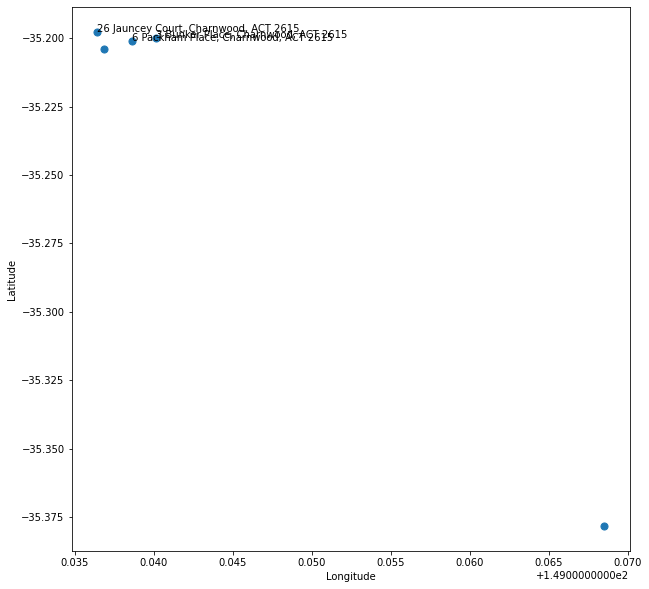

In [19]:
from matplotlib import pyplot as plt
addresses_df[:5].plot(kind="scatter", x="Longitude", y="Latitude", s=50, figsize=(10,10))

for i, label in enumerate(addresses_df[:5]):
    plt.annotate(addresses_df["Address"][i], (addresses_df["Longitude"][i], addresses_df["Latitude"][i]))
    
plt.show()

#### 5.2 Convert to common format - GeoJSON

Import Python conversion tools (shapely).

In [20]:
import shapely.wkt
from shapely.geometry import MultiPoint
import json

Loop through the graph using ordinary Python loops, not a query.

In [21]:
points_list = []

for s, p, o in g.triples((None, RDF.type, GNAF.Address)):
    for s2, p2, o2 in g.triples((s, GEO.hasGeometry, None)):
        for s3, p3, o3 in g.triples((o2, GEO.asWKT, None)):
            points_list.append(
                shapely.wkt.loads(str(o3).replace("<http://www.opengis.net/def/crs/EPSG/0/4283> ", ""))
            )

mp = MultiPoint(points=points_list)

geojson = shapely.geometry.mapping(mp)
print(json.dumps(geojson, indent=4))

{
    "type": "MultiPoint",
    "coordinates": [
        [
            149.06864966,
            -35.37733591
        ],
        [
            149.03046282,
            -35.20202762
        ],
        [
            149.03047333,
            -35.20156767
        ],
        [
            149.06860919,
            -35.37833726
        ],
        [
            149.03640841,
            -35.19777173
        ],
        [
            149.06946494,
            -35.37908886
        ],
        [
            149.06908395,
            -35.37882495
        ],
        [
            149.03048051,
            -35.20185603
        ],
        [
            149.03049843,
            -35.20169346
        ],
        [
            149.04029706,
            -35.19999611
        ],
        [
            149.0368852,
            -35.19795303
        ],
        [
            149.06895786,
            -35.37862878
        ],
        [
            149.03705032,
            -35.19796828
        ],
        [
      

Another, better, GeoJSON export - including Feature information.

First, build a Python dictionary matching the GeoJSON specification, then export it to JSON.

In [22]:
geo_json_features = []

# same query as above
for r in g.query(q):
    match = re.search("POINT\((\d+\.\d+)\s(\-\d+\.\d+)\)", r["coords"])
    long = float(match.group(1))
    lat = float(match.group(2))
    geo_json_features.append({
        "type": "Feature", 
        "properties": { "name": r["addr"] },
        "geometry": { 
            "type": "Point", 
            "coordinates": [ long, lat ] 
        } 
    })
    
geo_json_data = {
    "type": "FeatureCollection",
    "name": "test-points-short-named",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": geo_json_features
}

import json
geo_json = json.dumps(geo_json_data, indent=4)
print(geo_json)

{
    "type": "FeatureCollection",
    "name": "test-points-short-named",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "6 Packham Place, Charnwood, ACT 2615"
            },
            "geometry": {
                "type": "Point",
                "coordinates": [
                    149.03865604,
                    -35.20113263
                ]
            }
        },
        {
            "type": "Feature",
            "properties": {
                "name": "3 Bunker Place, Charnwood, ACT 2615"
            },
            "geometry": {
                "type": "Point",
                "coordinates": [
                    149.0401187,
                    -35.19989093
                ]
            }
        },
        {
            "type": "Feature",
            "properties": {
             

Export the data and view it in a GeoJSON map viewer, such as http://geojsonviewer.nsspot.net/ or QGIS (desktop_.

## Concluding remarks

* Semantic Web, realised through Linked Data, builds a global machine-readable data system
* the RDF data structure is used
    * to link things
    * to define things, and the links
* specialised parts of the Sem Web can represent a/any domain
    * e.g. spatial
    * e.g. Addresses
* powerful graph pattern matching queries, SPARQL, can be used to subset (federated) Sem Web data
* RDF manipulation libraries exist
    * can convert to other, common forms, e.g. CSV GeoJSON
* _do as much data science work as you can with well-defined models!_

## License
All the content in this repository is licensed under the [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). Basically, you can:

* copy and redistribute the material in any medium or format
* remix, transform, and build upon the material for any purpose, even commercially

You just need to:

* give appropriate credit, provide a link to the license, and indicate if changes were made
* not apply legal terms or technological measures that legally restrict others from doing anything the license permits

## Contact Information
**Dr Nicholas J. Car**<br />
*Data Systems Architect*<br />
[SURROUND Australia Pty Ltd](https://surroundaustralia.com)<br />
<nicholas.car@surroundaustralia.com><br />
GitHub: [nicholascar](https://github.com/nicholascar)<br />
ORCID: <https://orcid.org/0000-0002-8742-7730><br />